# 🩺 Pneumonia Detection with Deep Learning (PyTorch)

Diagnosis often involves imaging studies — which is why we’re building a **CNN** to detect it from chest X-rays.


This notebook walks through building a **Convolutional Neural Network (CNN)** to detect pneumonia from chest X-ray images.


We’ll start by preparing the dataset, then move step by step to model building, training, and evaluation.

In [ ]:
!pip install opendatasets

# 📦 Step 1: Installing and Setting Up Kaggle Dataset

We begin by installing **opendatasets** (a helper to fetch datasets directly from Kaggle) and securely loading our **Kaggle API credentials** stored in Colab.

👉This will allow us to download the pneumonia dataset without manual uploads.


In [ ]:
from google.colab import userdata
username = userdata.get('Kaggle_username')
key = userdata.get('kaggle_key')

# 📂 Step 2: Downloading the Chest X-Ray Pneumonia Dataset

We now download the **Chest X-Ray Pneumonia dataset** from Kaggle.  
This dataset contains chest radiographs labeled as **NORMAL** or **PNEUMONIA**, which we will use to train our model.


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: username
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:25<00:00, 94.9MB/s]


# 🛠 Step 3: Importing Required Libraries

Here we import the essential libraries:

- **os / cv2** → file handling & image preprocessing  
- **numpy** → numerical operations  
- **tqdm** → progress tracking  
- **Counter** → quick class frequency counts  
- **matplotlib / seaborn** → data visualization  
- **sklearn** → dataset splitting  

👉These will form the backbone of our preprocessing and analysis pipeline.


In [ ]:
import os  # for file/directory operations
import cv2  # computer vision library for image processing
import numpy as np  # array operations and math functions
import random  # for shuffling and sampling
from tqdm import tqdm  # to visualize long-running operations
from collections import Counter  # for counting frequency of elements
import matplotlib.pyplot as plt  # for creating graphs and charts
import seaborn as sns  # enhanced plotting with better aesthetics
from sklearn.model_selection import train_test_split  # for splitting data into train/test sets


# 📊 Step 4: Organizing the Dataset

We restructure the dataset into **train / validation / test splits**.

- Training: 80%  
- Validation: 10%  
- Testing: 10%  

Each split has separate folders for `NORMAL` and `PNEUMONIA`.  

👉This ensures a clean pipeline for training and evaluation.


In [ ]:
# Paths
INPUT_DIR = "/content/chest-xray-pneumonia/chest_xray/chest_xray"
OUTPUT_DIR = "/content/chest_xray_split"
SPLITS = ["train", "val", "test"]

# Collect all images by class (look 2 levels deep)
images_by_class = {}

for split in SPLITS:
    split_path = os.path.join(INPUT_DIR, split)
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            images_by_class[f"{split}_{class_name}"] = [
                os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]

### Debug: Print counts per split
for key, files in images_by_class.items():
    print(f"{key}: {len(files)} images")

# Flatten into class-separated lists (ignoring original splits)
all_normal_files = []
all_pneumonia_files = []

for key, files in images_by_class.items():
    if "NORMAL" in key:
        all_normal_files.extend(files)
    elif "PNEUMONIA" in key:
        all_pneumonia_files.extend(files)

print(f"\nTotal NORMAL: {len(all_normal_files)}")
print(f"Total PNEUMONIA: {len(all_pneumonia_files)}")

# Create output folder structure
for split in SPLITS:
    for label in ["NORMAL", "PNEUMONIA"]:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Split images deterministically (80% train, 10% val, 10% test)
def split_and_save(file_list, class_name):
    train_files, temp_files = train_test_split(file_list, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    split_dict = {
        "train": train_files,
        "val": val_files,
        "test": test_files
    }

    for split, files in split_dict.items():
        for filepath in tqdm(files, desc=f"Saving {split}/{class_name}"):
            img = cv2.imread(filepath)
            if img is None:
                continue
            filename = os.path.basename(filepath)
            save_path = os.path.join(OUTPUT_DIR, split, class_name, filename)
            cv2.imwrite(save_path, img)

# Process each class
split_and_save(all_normal_files, "NORMAL")
split_and_save(all_pneumonia_files, "PNEUMONIA")

print("✅ Dataset saved in:", OUTPUT_DIR)


train_NORMAL: 1341 images
train_PNEUMONIA: 3875 images
val_NORMAL: 8 images
val_PNEUMONIA: 8 images
test_NORMAL: 234 images
test_PNEUMONIA: 390 images

Total NORMAL: 1583
Total PNEUMONIA: 4273


Saving test/PNEUMONIA: 100%|██████████| 428/428 [00:03<00:00, 122.19it/s]

✅ Dataset saved in: /content/chest_xray_split


## As we can see from the above output 👆, we have in total **5856** images for this dataset ( **1538** Normal, **4273** infected )

# 🔍 Step 5: Loading and Preprocessing Images

Each image goes through these preprocessing steps:

1. Convert to **grayscale** (color is not needed for X-rays).  
2. Resize to **224 × 224 pixels** (uniform size).  
3. Normalize pixel values to **[0,1] range**.  
4. Expand dimensions to match PyTorch input format.  

Labels are mapped as:  
- `0 = NORMAL`  
- `1 = PNEUMONIA`


In [ ]:

# Define the root directory that contains the split folders
ROOT_DIR = "/content/chest_xray_split"

# Keep track of the splits you want to load
SPLITS = ["train", "val", "test"]

# Map string labels to integers for model-friendly targets
LABEL_MAP = {"NORMAL": 0, "PNEUMONIA": 1}

def load_split(split_name, target_size=(224, 224), normalize=True):
    """
    Read every image inside ROOT_DIR / split_name / class_label,
    convert it to grayscale, resize, normalize (optional),
    expand the channel dimension, and return the images with labels.
    """
    images = []
    labels = []
    bad_files = []

    # Build the split path
    split_path = os.path.join(ROOT_DIR, split_name)

    for class_name, class_index in LABEL_MAP.items():
        class_path = os.path.join(split_path, class_name)
        if not os.path.exists(class_path):
            continue

        # Iterate through files in the class folder
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Get file extension safely
            _, ext = os.path.splitext(filename)
            if ext.lower() not in {".jpg", ".jpeg", ".png"}:
                continue

            # Read the image directly in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                bad_files.append(image_path)
                continue

            # Resize to a fixed target size
            if target_size is not None:
                img = cv2.resize(img, target_size)

            # Normalize pixel values (0–1 range)
            if normalize:
                img = img.astype("float32") / 255.0

            # Expand channel axis to (H, W, 1)
            img = np.expand_dims(img, axis=-1)

            images.append(img)
            labels.append(class_index)

    if bad_files:
        print(f"[WARNING] Skipped {len(bad_files)} corrupted files in '{split_name}'")

    return images, labels


# Load every split using the reusable function
x_train, y_train = load_split("train")
x_val, y_val     = load_split("val")
x_test, y_test   = load_split("test")

# Convert lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_val,   y_val   = np.array(x_val),   np.array(y_val)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

# Display the dataset stats
print(f"Train set: {x_train.shape}, labels: {y_train.shape}")
print(f"Validation set: {x_val.shape}, labels: {y_val.shape}")
print(f"Test set: {x_test.shape}, labels: {y_test.shape}")

# Show class balance
print("Class balance in train:", Counter(y_train))
print("Class balance in val:  ", Counter(y_val))
print("Class balance in test: ", Counter(y_test))


Train set: (4684, 224, 224, 1), labels: (4684,)
Validation set: (585, 224, 224, 1), labels: (585,)
Test set: (587, 224, 224, 1), labels: (587,)
Class balance in train: Counter({np.int64(1): 3418, np.int64(0): 1266})
Class balance in val:   Counter({np.int64(1): 427, np.int64(0): 158})
Class balance in test:  Counter({np.int64(1): 428, np.int64(0): 159})


# 👀 Step 6: Visualizing Sample Images

To validate our preprocessing, we plot a random batch of images.  
Each tile shows:  

- The X-ray (in grayscale)  
- Its **class label** (Normal or Pneumonia)  
- The image dimensions  

This helps confirm that resizing and normalization are working correctly.


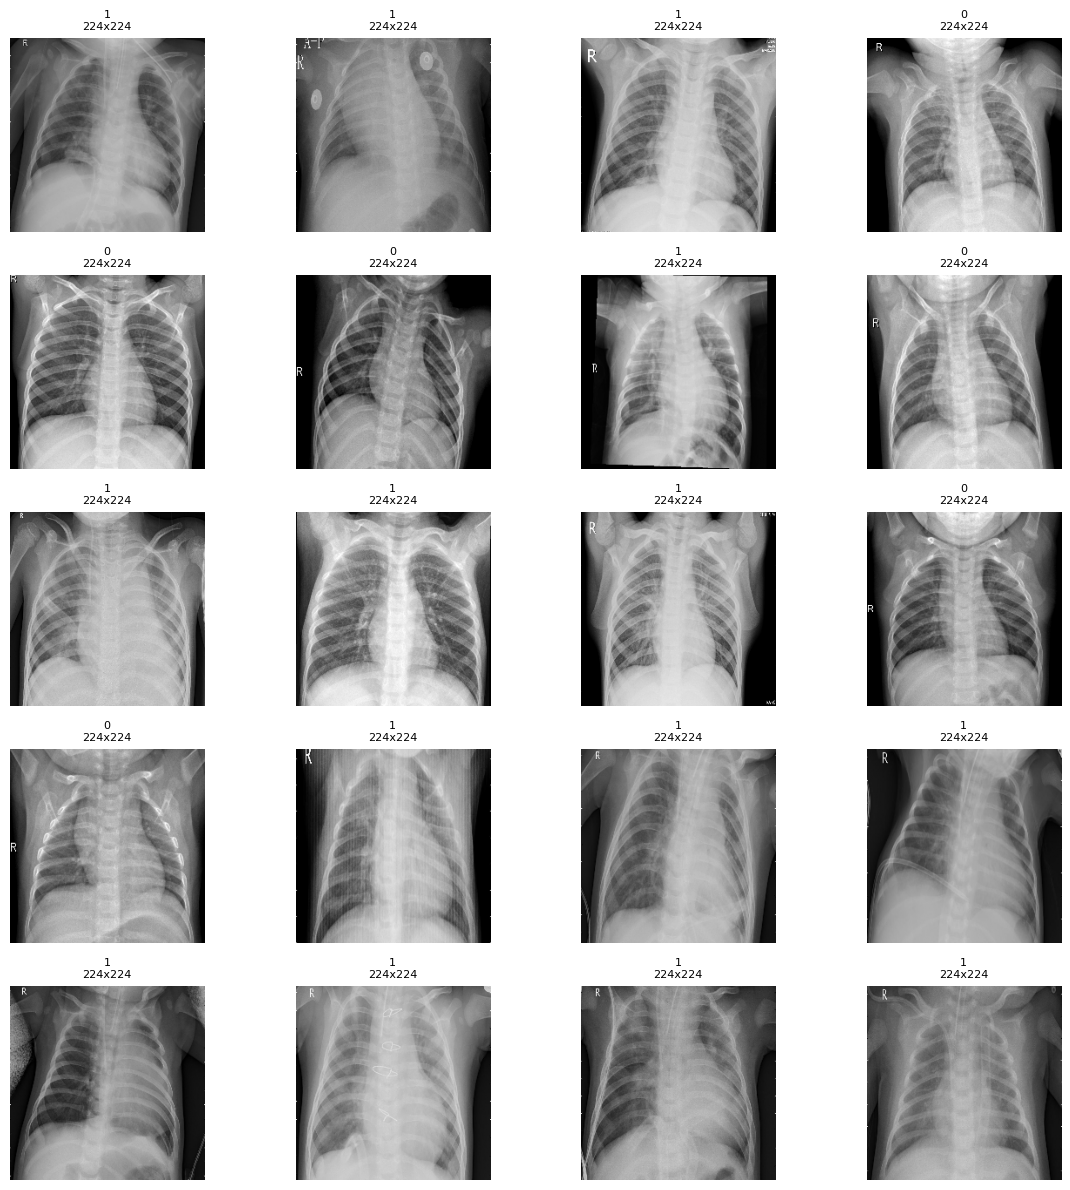

In [ ]:


# Pick 20 random indices
indices = random.sample(range(len(x_train)), 20)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    plt.subplot(5, 4, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    img_shape = x_train[idx].shape
    plt.title(f"{ y_train[idx]}\n{img_shape[0]}x{img_shape[1]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Let's take a look at the shape of our training/testing shapes

In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (4684, 224, 224, 1)
Shape of y_train: (4684,)
Shape of x_val: (585, 224, 224, 1)
Shape of y_val: (585,)
Shape of x_test: (587, 224, 224, 1)
Shape of y_test: (587,)


These shapes don't match Pytorch's expected shapes so..

# 🔄 Step 7: Converting Data to PyTorch Tensors

We now convert the numpy arrays into **PyTorch tensors**.

- Shape is reordered from `(N, H, W, C)` → `(N, C, H, W)`  
- This matches PyTorch’s convention: **channel-first format**  

This makes the dataset ready for the model.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Convert your existing NumPy arrays to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.LongTensor(y_train)

x_val_tensor = torch.FloatTensor(x_val).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_val_tensor = torch.LongTensor(y_val)

x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_test_tensor = torch.LongTensor(y_test)

print(f"Train: {x_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Val: {x_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test: {x_test_tensor.shape}, {y_test_tensor.shape}")

Train: torch.Size([4684, 1, 224, 224]), torch.Size([4684])
Val: torch.Size([585, 1, 224, 224]), torch.Size([585])
Test: torch.Size([587, 1, 224, 224]), torch.Size([587])


# 📦 Step 8: Creating Custom Dataset & DataLoader

We wrap our data in a **PyTorch Dataset class**, which allows:

- Easy indexing (`__getitem__`)  
- Batch loading via **DataLoader**  
- Shuffling of samples  

We also apply a **WeightedRandomSampler** to deal with **class imbalance** (pneumonia cases outnumber normal ones).


In [ ]:
# Alternate to TensorDataset but from scratch :)
class ChestXRayDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    # Required by DataLoader to know when to stop iterating
    def __len__(self):
        return len(self.images)

    # Required by DataLoader to fetch individual samples during batch creation
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Create datasets
train_dataset = ChestXRayDataset(x_train_tensor, y_train_tensor)
val_dataset = ChestXRayDataset(x_val_tensor, y_val_tensor)
test_dataset = ChestXRayDataset(x_test_tensor, y_test_tensor)

In [ ]:
# Calculate class weights for sampler
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {0: total_samples / class_counts[0],  # NORMAL
                 1: total_samples / class_counts[1]}   # PNEUMONIA

# Create sample weights for each training example
sample_weights = [class_weights[label.item()] for label in y_train_tensor]

# Create weighted sampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🧠 Step 9: Building the CNN Model

We define our **Convolutional Neural Network (CNN)**:

- 4 Convolutional Blocks → (Conv → BatchNorm → ReLU → Conv → BatchNorm → ReLU → MaxPool)  
- Global Average Pooling → compress spatial info  
- Dropout (0.4) → reduce overfitting  
- Fully Connected Layer → outputs 2 classes (Normal, Pneumonia)  

This model has **~1.17M parameters**.


In [ ]:
class PneumoniaCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):  # 1 in channels: Grayscaled images, 2 classes: NORMAL and PNEUMONIA
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),    # 3x3 conv
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.Conv2d(out_c, out_c, 3, padding=1),   # 3x3 conv (more complex features)
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.MaxPool2d(2)                          # MaxPol (reduce dimensions by half)
            )

        self.layer1 = conv_block(in_channels, 32)        # first conv block (1 -> 32)
        self.layer2 = conv_block(32, 64)                 # second conv block (32 -> 64)
        self.layer3 = conv_block(64, 128)                # third conv block (64 -> 128)
        self.layer4 = conv_block(128, 256)               # forth conv block (128 -> 256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # converts size to (256, 1, 1)
        self.dropout = nn.Dropout(0.4)                   # random 40% dropout
        self.fc = nn.Linear(256, num_classes)            # fully connected layer (256 -> 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Initialize the model
model = PneumoniaCNN(num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 1,174,114


# ⚡ Step 10: Training the Model

We set up:

- **Optimizer:** Adam (lr = 0.001)  
- **Loss Function:** CrossEntropyLoss  
- **Epochs:** 20  

During training, we track:  
- Training Loss & Accuracy  
- Validation Loss & Accuracy  

The **best-performing model** (highest validation accuracy) is saved as `best_pneumonia_model.pth`.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_pneumonia_model.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

Epoch [1/20]
Train Loss: 0.3043, Train Acc: 88.09%
Val Loss: 0.2249, Val Acc: 91.97%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.2142, Train Acc: 91.91%
Val Loss: 0.3454, Val Acc: 86.15%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.2000, Train Acc: 92.34%
Val Loss: 0.2108, Val Acc: 90.94%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1695, Train Acc: 93.68%
Val Loss: 0.5166, Val Acc: 80.34%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1630, Train Acc: 93.30%
Val Loss: 0.1631, Val Acc: 94.19%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.1568, Train Acc: 94.00%
Val Loss: 0.2045, Val Acc: 91.79%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1507, Train Acc: 94.17%
Val Loss: 0.4036, Val Acc: 82.91%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.1425, Train Acc: 94.4

We observe that training accuracy continues to improve with each epoch, but **validation accuracy peaks at epoch 14** and then begins to decline. This indicates the model is starting to increase in Variance (overfit-capturing nois) in the training data rather than generalizing well.

To achieve the best **bias-variance trade-off, we save the model checkpoint from epoch 14**, where validation performance is optimal.

# 📈 Step 11: Evaluating the Model

We reload the saved best model and evaluate it on the **test set**.  
We compute:  

- Accuracy  
- Precision, Recall, F1-score  
- AUC (Area Under ROC Curve)  

**Results:**  
- Accuracy ≈ **95.7%**  
- AUC ≈ **0.99** 🎉


In [ ]:
import torch.nn.functional as F

# Model evaluation
def evaluate_model(model, test_loader):
    model.eval()
    model.load_state_dict(torch.load('best_pneumonia_model.pth'))

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = to_device(images, device), to_device(labels, device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Pneumonia probability

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

# Evaluate
evaluate_model(model, test_loader)

Test Accuracy: 0.9574
Test Precision: 0.9575
Test Recall: 0.9574
Test F1-Score: 0.9575
Test AUC: 0.9913


# 🌀 Step 12: Confusion Matrix

We plot the **confusion matrix** to see how well the model distinguishes:

- **True Positives** (Pneumonia correctly detected)  
- **True Negatives** (Normal correctly detected)  
- **False Positives / False Negatives**  

This gives insight into misclassifications.  
Final metrics are displayed beneath the matrix.


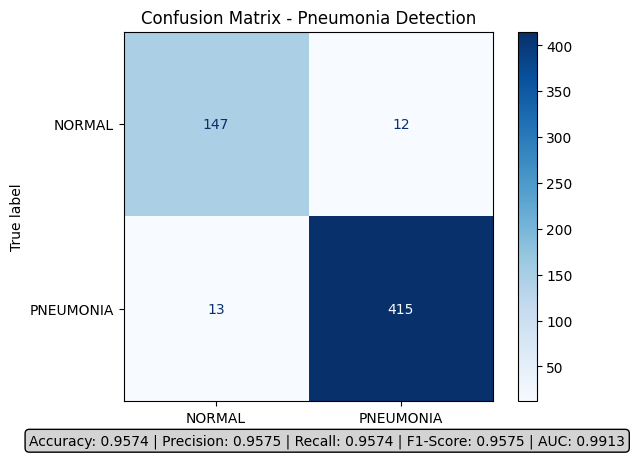

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_simple(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=["NORMAL", "PNEUMONIA"], cmap="Blues", values_format="d"

    )
    plt.figtext(0.02, 0.02,
                f'Accuracy: {0.9574:.4f} | Precision: {0.9575:.4f} | '
                f'Recall: {0.9574:.4f} | F1-Score: {0.9575:.4f} | AUC: {0.9913:.4f}',
                ha='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    disp.ax_.set_title("Confusion Matrix - Pneumonia Detection")
    plt.show()

plot_confusion_matrix_simple(model, test_loader, device)


# 🎯 Final Summary

In this notebook, we:

✅ Built a CNN from scratch in PyTorch  
✅ Handled dataset imbalance with weighted sampling  
✅ Achieved **~96% accuracy** and **AUC 0.99**  

📌 Next steps for improvement:  
- Data augmentation (rotations, flips, contrast changes)  
- Hyperparameter tuning  
- Trying transfer learning (e.g., ResNet, DenseNet)

This project demonstrates how deep learning can assist in **medical image diagnosis**.

Made by Youssef El Demerdash